Preamble

In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.ma as ma


from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm


# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%matplotlib inline

# Calculating the G, the normalized correlation function

In [2]:
def Calculate_G(image_names, start, time, lags):
    "this function takes image names, a sequence of time and a desired amount of lags"
    "and calculates G, mean quantities, maps"

    def calculate_G(metapixels_a, metapixels_b):
        "this function calculates the value of the normalized correlation"
        "function between metapixels"
        a = np.nanmean((metapixels_a * metapixels_b), axis=(2, 3))
        b = np.nanmean(metapixels_a, axis=(2, 3))
        c = np.nanmean(metapixels_b, axis=(2, 3))
        d = np.nanstd(metapixels_a, axis=(2, 3))
        e = np.nanstd(metapixels_b, axis=(2, 3))

        G = (a - (b * c)) / (d * e)
        return G

    def wholefield_stats(spatial_map, mask):
        map_mean = []
        map_var = []
        for i in range(len(spatial_map)):
            masked_map = ma.masked_array(spatial_map[i], mask=mask)
            map_mean.append(np.nanmean(masked_map))
            map_var.append(np.nanvar(masked_map))
        map_mean = np.asarray(map_mean)
        map_var = np.asarray(map_var)
        return map_mean  #, map_var
##################################################################################################################

#this variable is a list which contains each timestep

    G_time_lags = [[] for _ in range(len(time))]
    sandpile_mean = [[] for _ in range(len(time))]
    sandpile_var = [[] for _ in range(len(time))]

    i = 0

    # this is the size of the metapixels, defined outside of the loop
    size = 10

    for t in time:
        #this is just to make t an interger rather than a float so that t can be used as a list index
        t = int(t)

        #the index of each image (i.e. the frame number) is the iterator t plus 11, the time where grains first
        #enter the frame
        speckle_a = Image.open(image_names[t + start])
        speckle_a = np.asarray(speckle_a)[y_min:y_max, x_min:x_max]

        lenr, lenc = int(speckle_a.shape[0] / size), int(speckle_a.shape[1] /
                                                         size)
        metapixels_a = speckle_a.reshape(lenr, size, lenc,
                                         size).transpose(0, 2, 1, 3)

        mp_a_mean = np.nanmean(metapixels_a, axis=(2, 3))
        metapixels_a = np.subtract(metapixels_a,
                                   mp_a_mean[..., np.newaxis, np.newaxis])

##################################################################################################################
        l = 0
        G_lags = [[] for _ in range(lags)]

        # this loop is for each lag
        for lag in range(lags):

            # choosing two speckle images
            speckle_b = Image.open(image_names[lag + t + start])
            speckle_b = np.asarray(speckle_b)[y_min:y_max, x_min:x_max]

            metapixels_b = speckle_b.reshape(lenr, size, lenc,
                                             size).transpose(0, 2, 1, 3)
            mp_b_mean = np.nanmean(metapixels_b, axis=(2, 3))
            metapixels_b = np.subtract(metapixels_b, 
                                       mp_b_mean[..., np.newaxis, np.newaxis])

            G_lags[l] = (calculate_G(metapixels_a, metapixels_b))
            
            l += 1
##################################################################################################################
        G_time_lags[i] = G_lags
        sandpile_mean[i] = wholefield_stats(G_time_lags[i], mask=~binary)

        i += 1
        print(t+start)

    return G_time_lags, sandpile_mean

# Undisturbed

## Loading images

In [3]:
os.chdir('/media/nakul/Backup Plus/Data/DWS_RawExperimentPhotos/feb_12/undisturbed')

In [4]:
import glob
import natsort

image_names = []

for name in glob.glob('img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

## Creating masks

In [5]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1900
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

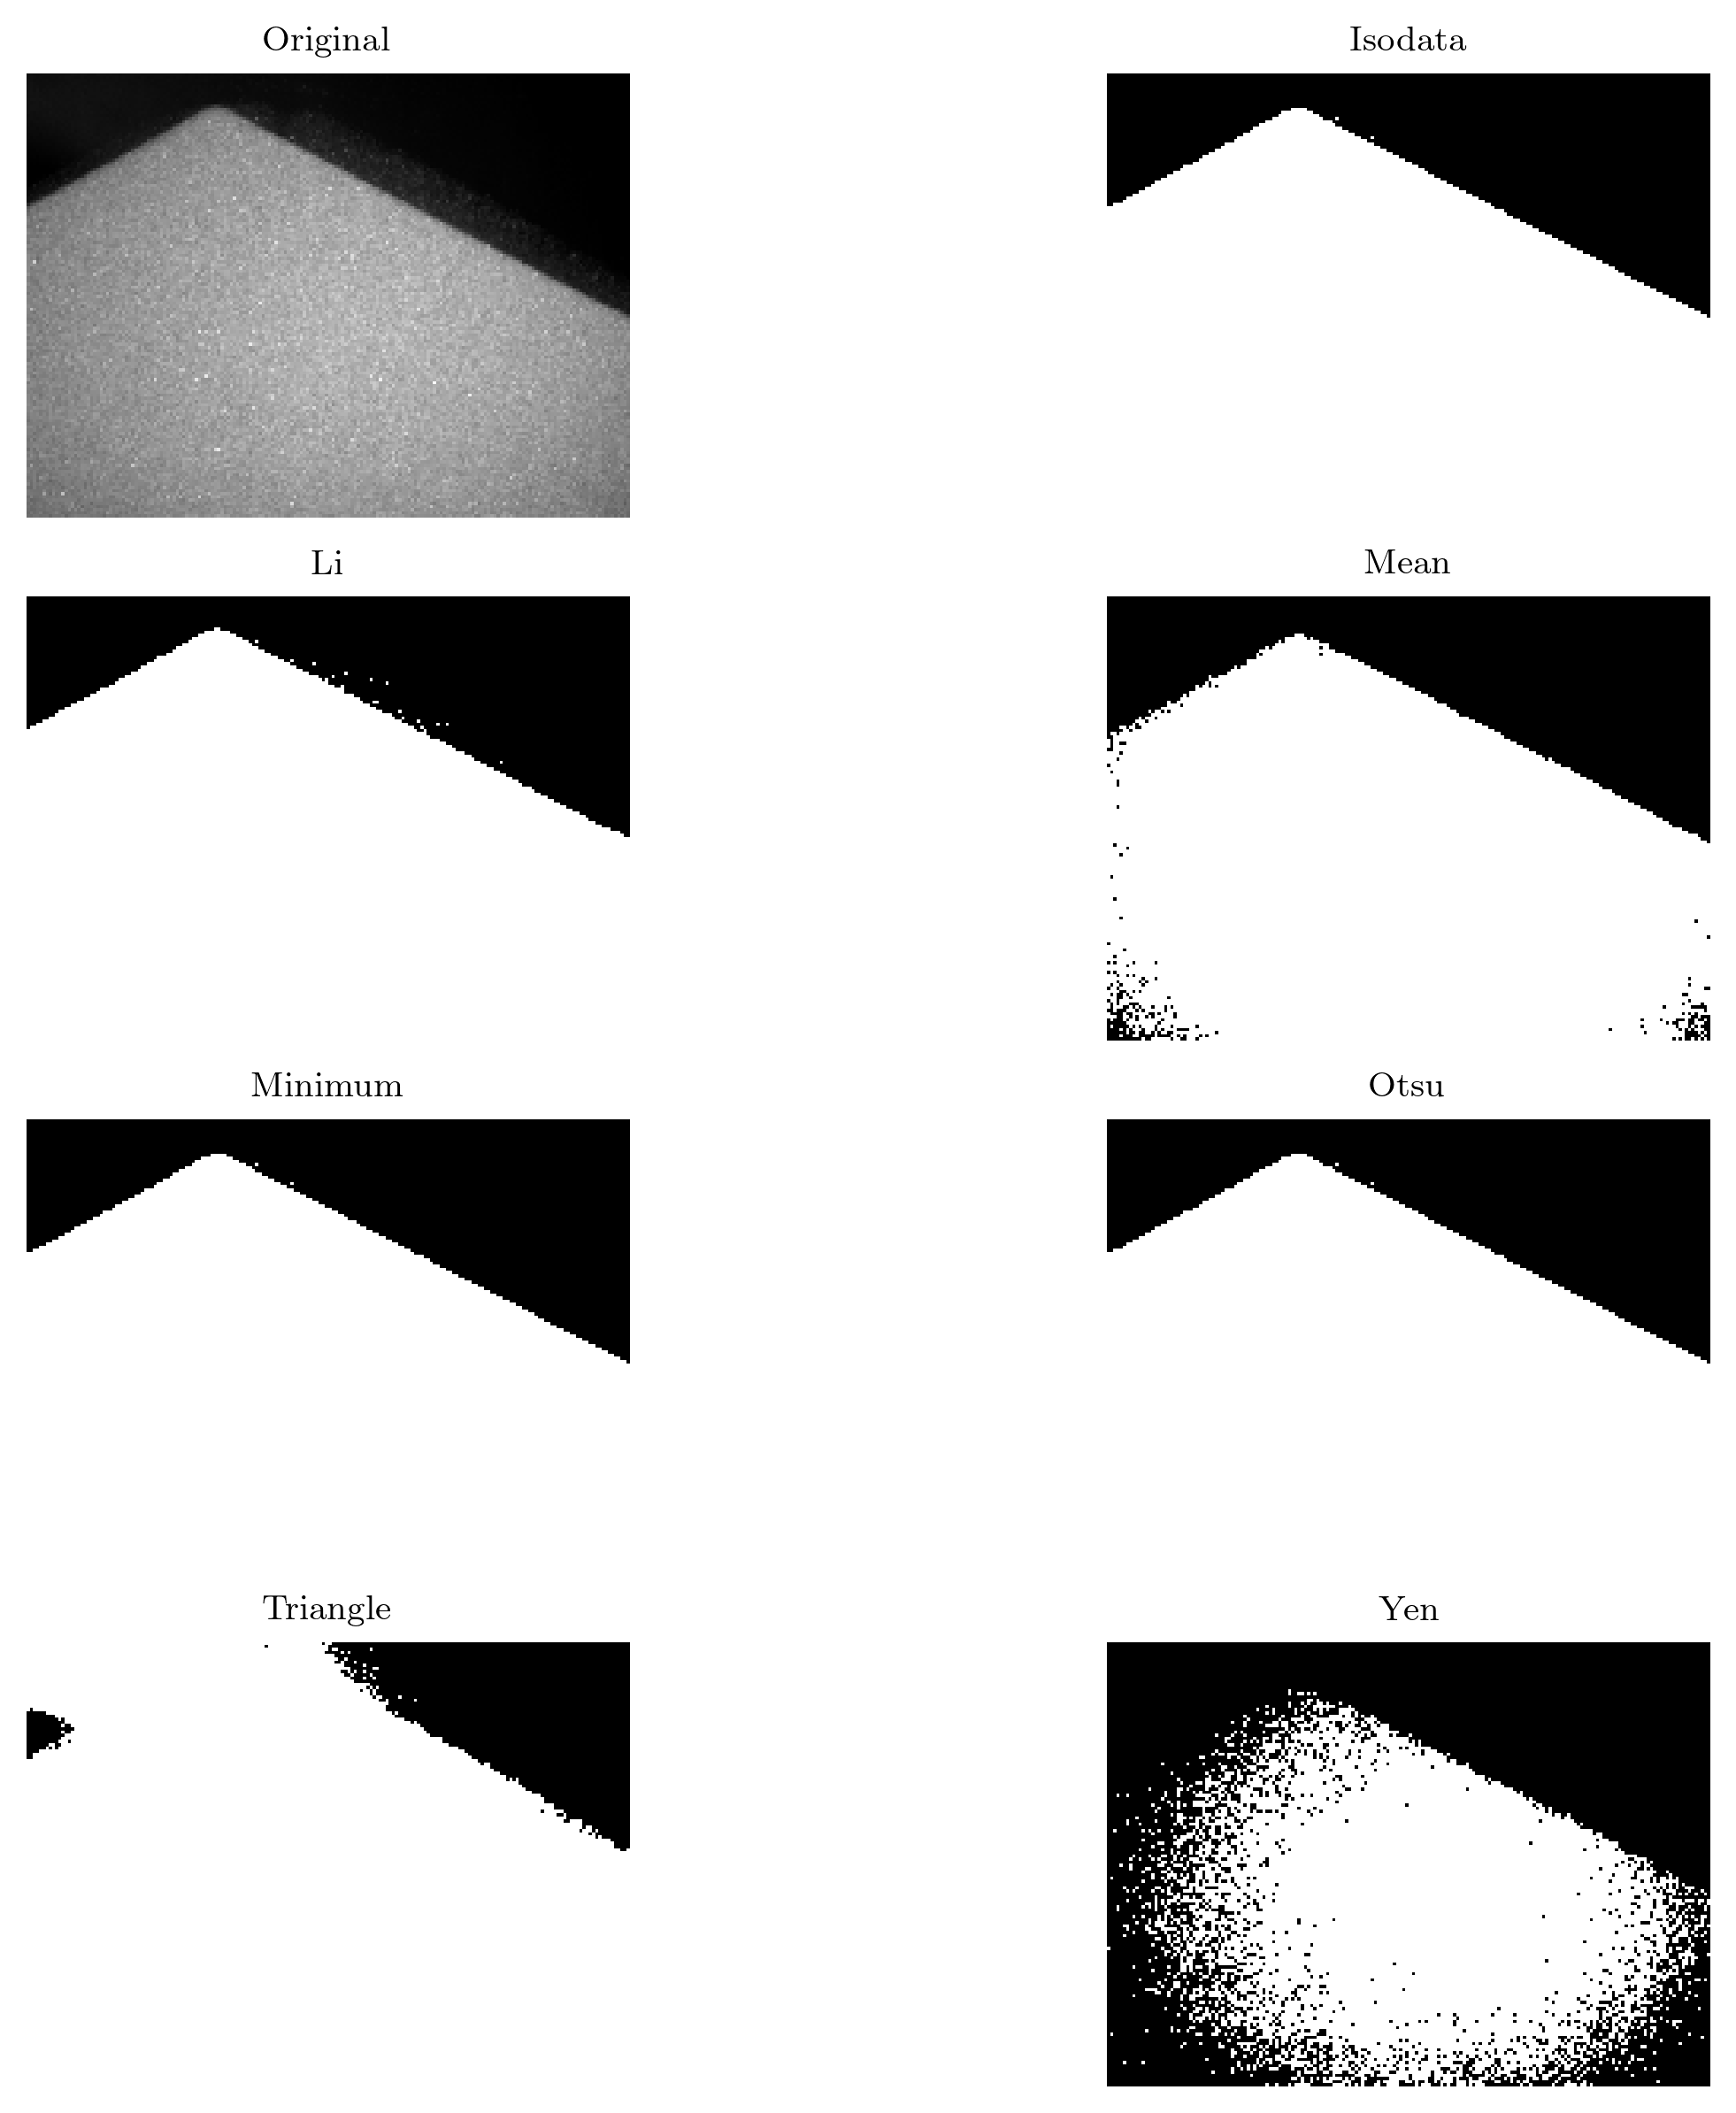

In [6]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)


plt.show()

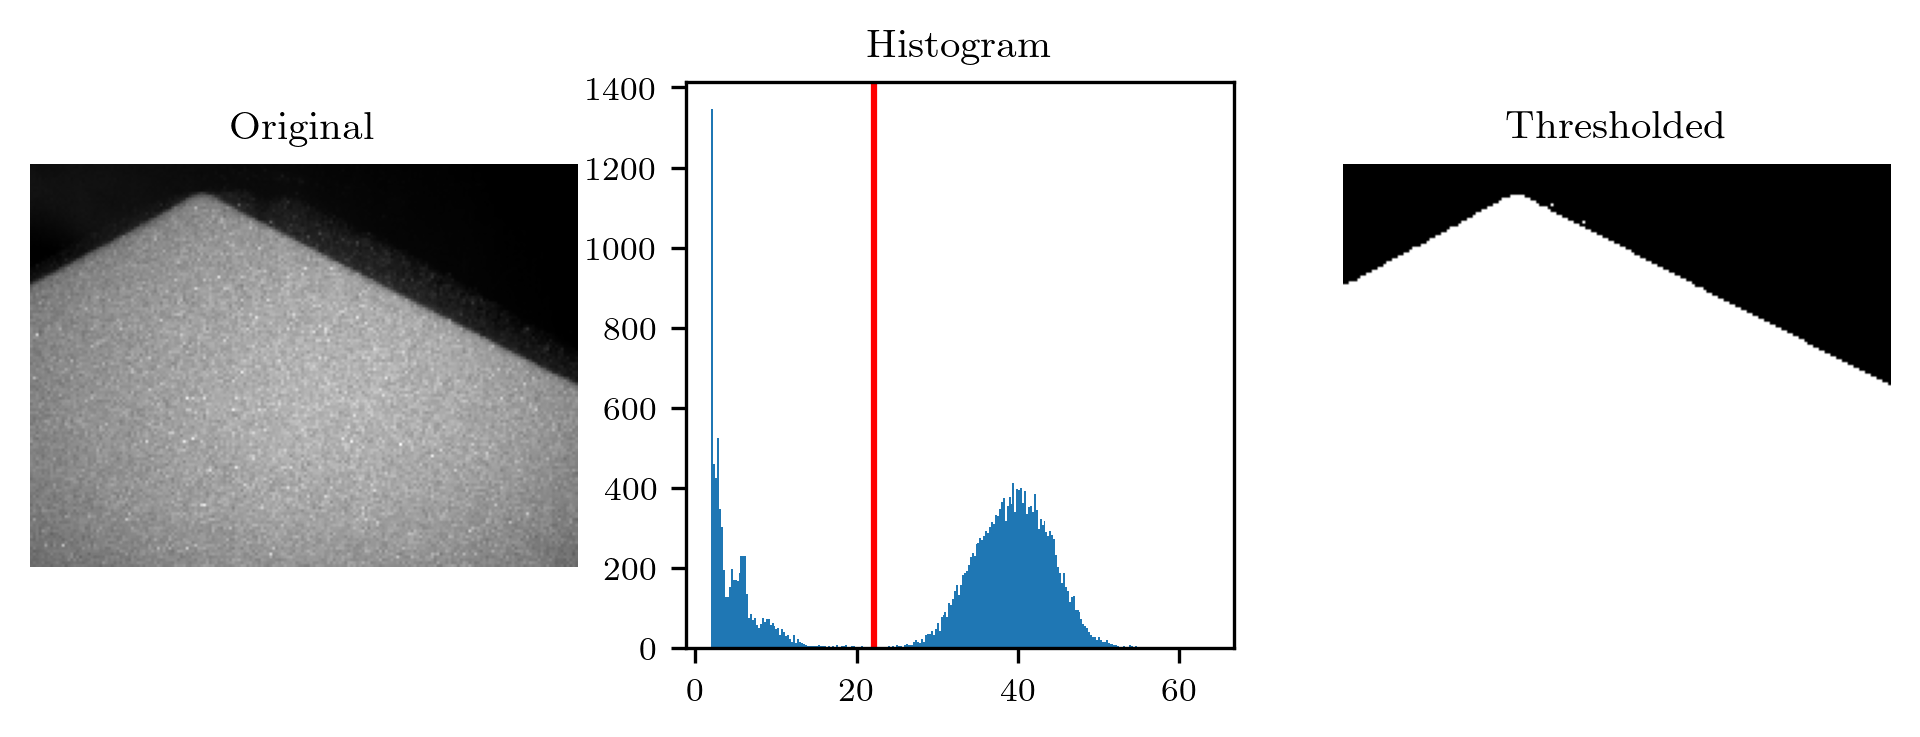

In [7]:
from skimage.filters import threshold_otsu

image = mp_a_mean
thresh = threshold_otsu(image)
binary = image > thresh
mask_sand = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## Calculating G

In [ ]:
# time = np.logspace(1, 13, num=13, base=2)
# time = (1,2)
time = np.arange (0,90,1)

correlation_undisturbed, means_undisturbed = Calculate_G(image_names,0,time,2)

### Saving data

In [ ]:
#this saves G at 1000 lags. 
np.savez('purecreep_C',data1 = correlation_undisturbed, data2 = means_undisturbed)

## Loading 1000 lag correlations at 13 start times

In [8]:
os.chdir('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb')

In [9]:
undisturbed = np.load('undisturbed_creep_feb12.npz')
correlation_undisturbed = undisturbed['data1']
# means_undisturbed = undisturbed['data2']

## Loading 1 lag correlations at all starts (instantaneous rates)

In [ ]:
undisturbed_dt = np.load('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/undisturbed_creep_strainrate_feb12.npz')
correlation_undisturbed_dt = undisturbed_dt['data1']
# means_undisturbed_dt = undisturbed_dt['data2']

## Loading 1000 lag correlations 11 days from preparation

In [ ]:
os.chdir('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/11_day')

In [ ]:
undisturbed_day11 = np.load('feb_27_DAY11.npz')
correlation_undisturbed_day11 = undisturbed_day11['data1']
means_undisturbed_day11 = undisturbed_day11['data2']

## Mapping from G to strain

In [ ]:
d = 1e-4
strain_rate = 1e-5
l = 3.3*d
velocity = strain_rate*l
seconds_in_year = 3.154e+7

In [ ]:
speed = velocity * seconds_in_year

In [ ]:
downlope_speed = speed*np.sin(np.deg2rad(30))

In [ ]:
compaction_speed = speed*np.cos(np.deg2rad(30))
compaction_speed

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
G = np.arange(0,1,.01)
strain = -(np.log(G)/c) 

fig = plt.figure(figsize=(6, 4))

plt.plot(G,strain)
plt.ylabel('$\epsilon$')
plt.xlabel('G')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# plt.savefig('mapping_G_to_strain.png')

# 2d maps

## Three panel ensemble map

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

# fig = plt.figure(figsize=(7, 3))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
# ax4 = plt.subplot(1, 4, 4)
#################################################################################################################
frame = correlation_undisturbed[0][1]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)

# ax1.annotate('t = 2 s', xy=(5, 5), xytext=(125, 20),fontsize = 8)
# ax1.annotate('τ = 1', xy=(5, 5), xytext=(125, 35),fontsize = 8)

ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
frame = correlation_undisturbed_dt[3][1]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
# ax2.annotate('t = 16 s', xy=(5, 5), xytext=(125, 20),fontsize = 8)
# ax2.annotate('τ = 1', xy=(5, 5), xytext=(125, 35),fontsize = 8)

# ax2.set_title('t = 64 s')#,fontsize = 20);
ax2.set_xticks([]);
ax2.set_yticks([]);
#################################################################################################################
frame = correlation_undisturbed[9][10]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im3 = ax3.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title(r'$\dot{\epsilon }   [1/s]$',fontsize = 6)
# ax3.annotate('t = 1024s', xy=(5, 5), xytext=(115, 20),fontsize = 8)
# # ax3.annotate('τ = 10', xy=(5, 5), xytext=(115, 35),fontsize = 8)

# ax3.set_title('t = 256 s')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax3.set_xticks([]);
ax3.set_yticks([]);
#################################################################################################################
# frame = correlation_undisturbed[12][100]
# masked_map = ma.masked_array(frame, mask=~binary)
# masked_map[masked_map <= 0] == 0
# masked_map = -(np.log(masked_map)/c) 

# im4 = ax4.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')
# cmap = plt.cm.gray
# cmap.set_bad('white',1.)

# # divider = make_axes_locatable(ax4)
# # cax = divider.append_axes('right', size='3%', pad=0.05)
# # fig.colorbar(im4, cax=cax, orientation='vertical',format='%.0e')
# # # cax.tick_params(labelsize=15) 
# # cax.set_title('$\epsilon$',fontsize = 10)

# # ax4.annotate('t  = 8192 s', xy=(5, 5), xytext=(125, 20),fontsize = 8)
# # ax4.annotate('τ = 100', xy=(5, 5), xytext=(125, 35),fontsize = 8)

# # ax4.set_title('t = 8192 s')#,fontsize = 20);
# ax4.set_xticks([]);
# ax4.set_yticks([]);

# # plt.subplots_adjust(hspace=.02, wspace=.05, bottom=.1, left=.3, top=1)

# fit subplots and save fig
# fig.set_size_inches(w=7,h=3)
# fig.tight_layout()
# fig_name = 'fig1_panels.svg'
# plt.savefig(fig_name)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

# fig = plt.figure(figsize=(7, 3))

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
#################################################################################################################
frame = correlation_undisturbed_dt[0][1]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)

# ax1.annotate('t = 2 s', xy=(5, 5), xytext=(125, 20),fontsize = 8)
# ax1.annotate('τ = 1', xy=(5, 5), xytext=(125, 35),fontsize = 8)

ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
frame = correlation_undisturbed_dt[10][1]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
# ax2.annotate('t = 16 s', xy=(5, 5), xytext=(125, 20),fontsize = 8)
# ax2.annotate('τ = 1', xy=(5, 5), xytext=(125, 35),fontsize = 8)

# ax2.set_title('t = 64 s')#,fontsize = 20);
ax2.set_xticks([]);
ax2.set_yticks([]);
#################################################################################################################
frame = correlation_undisturbed_dt[20][1]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im3 = ax3.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title(r'$\dot{\epsilon }   [1/s]$',fontsize = 6)
# ax3.annotate('t = 1024s', xy=(5, 5), xytext=(115, 20),fontsize = 8)
# # ax3.annotate('τ = 10', xy=(5, 5), xytext=(115, 35),fontsize = 8)

# ax3.set_title('t = 256 s')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax3.set_xticks([]);
ax3.set_yticks([]);
#################################################################################################################
frame = correlation_undisturbed_dt[30][1]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 

im4 = ax4.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')
cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax4)
# cax = divider.append_axes('right', size='3%', pad=0.05)
# fig.colorbar(im4, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)

# ax4.annotate('t  = 8192 s', xy=(5, 5), xytext=(125, 20),fontsize = 8)
# ax4.annotate('τ = 100', xy=(5, 5), xytext=(125, 35),fontsize = 8)

# ax4.set_title('t = 8192 s')#,fontsize = 20);
ax4.set_xticks([]);
ax4.set_yticks([]);

# plt.subplots_adjust(hspace=.02, wspace=.05, bottom=.1, left=.3, top=1)

# fit subplots and save fig
fig.set_size_inches(w=7,h=3)
fig.tight_layout()
fig_name = 'fig1_panels.svg'
plt.savefig(fig_name)

## Maps of instantaneous strain

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

########################################################################################
fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 1, 1)
########################################################################################
frame = correlation_undisturbed_day11[9][10]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
masked_map = -(np.log(masked_map)/c) 
im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')
cmap = plt.cm.gray
cmap.set_bad('white',1.)
########################################################################################
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',format=ticker.FuncFormatter(fmt))
# cax.tick_params(labelsize=15) 
cax.set_title(r'$\dot{\epsilon}[s^{-1}]$',fontsize = 14)
ax1.set_xticks([]);
ax1.set_yticks([]);
########################################################################################
# plt.savefig('day1.jpg',bbox_inches='tight')

## histograms

In [ ]:
from skimage import exposure

A = masked_map
bins = 100

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.hist(A[~np.isnan(A)],bins=10,histtype='step', color='black')

# (bins, img_cdf, 'r')

img_cdf, bins = exposure.cumulative_distribution(A[~np.isnan(A)], bins)

ax2.plot(bins,1 - img_cdf, 'r')

ax1.set_xlabel('G')
ax1.set_ylabel(' of metapixels', color='k')
ax2.set_ylabel('cdf', color='r')

plt.show()

# Calculating means

In [10]:
def wholefield_stats(spatial_map,mask):
    
    n = len(spatial_map)
    G_mean = [[] for _ in range(n)]
    χ4 = [[] for _ in range(n)]
    
    for i in range(n):
        map_mean = []
        map_var = []
        temp_map = spatial_map[i]
        
        for j in range(len(temp_map)):
            masked_map = ma.masked_array(temp_map[j], mask= mask)
            map_mean.append(np.nanmean(masked_map))
            map_var.append(np.nanvar(masked_map))
            
        map_mean = np.asarray(map_mean)
        map_var = np.asarray(map_var)
        
        χ4[i] = map_var
        G_mean[i] = map_mean 
    return G_mean#,χ4

In [11]:
means_undisturbed = wholefield_stats(correlation_undisturbed, mask = ~binary)

In [12]:
def remove_outliers(correlation_function):
    "this function takes a correlation function and filters values."
    "at certain lag times, the mean drops to an anomalous value but is recovered at the subsequent lag time"
    "if the difference between two subsequent timesteps"
    "is greater than the difference between three timesteps, then we set the anomalous value to the previous value"
    x = correlation_function
    n = len(x)
    for i in range(n-2):
        a = x[i]
        b = x[i+1]
        c = x[i+2]
        d = abs(a-b)
        e = abs(a-c)
        if d > e:
            x[i+1] = x[i]
    return x

In [13]:
n = 13

for i in range(13):
    means_undisturbed[i] = remove_outliers(means_undisturbed[i])

# Time series of instantaneous creep rates

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

timeseries = []

for i in range(len(means_undisturbed_dt)):
    timeseries.append(means_undisturbed_dt[i][1])
    
fig = plt.figure(figsize=(6,2))


undisturbed_def = -(np.log(timeseries)/c) 
plt.plot(undisturbed_def[0:500],'k',alpha = 1)
plt.ylabel(r'$\langle \dot{\epsilon }\rangle$',fontsize = 7)
plt.xlabel('time (seconds)')
plt.yscale('log')

# # fit subplots and save fig
# fig.set_size_inches(w=7,h=2)
# fig.tight_layout()
# fig_name = 'undisturbed_instantaneous_creep.png'
# plt.savefig(fig_name)

In [ ]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

fig = plt.figure(figsize=(6, 2))
########################################################################################
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
########################################################################################
frame = correlation_undisturbed[9][100]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] == 0
# masked_map = -(np.log(masked_map)/c) 
im1 = ax1.imshow(masked_map,vmin = 0.9,vmax = 1,cmap = 'gray')
# ax1.annotate('t = 2 s', xy=(5, 5), xytext=(125, 20),fontsize = 10)

cmap = plt.cm.gray
cmap.set_bad('white',1.)
########################################################################################
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')#,format = '%.3f')#,format=ticker.FuncFormatter(fmt))
# cax.tick_params(labelsize=15) 
cax.set_title(r'$G$',fontsize = 12)
# ax1.set_title('t = 8192 s')
ax1.set_xticks([]);
ax1.set_yticks([]);
########################################################################################
time = np.arange(0,101,1)
ax2.plot(means_undisturbed[9],'k',alpha = 1)
ax2.set_xscale('log')
# ax2.plot(i,undisturbed_def[i],'ro',markeredgecolor = 'k')
ax2.set_ylabel(r'$\langle G \rangle$',fontsize = 12)
ax2.set_xlabel(r'$ t $ (s)')


fig.tight_layout()
# plt.savefig('undisturbed_frame.png',bbox_inches='tight')

# Movie/Animation frames

In [ ]:
fig = plt.figure(figsize=(6, 2))

from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
n = 0
time = np.arange(0,1000,1)


for i in range(151):

    ########################################################################################
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    ########################################################################################
    frame = correlation_undisturbed[12][i]
    masked_map = ma.masked_array(frame, mask=~binary)
    masked_map[masked_map <= 0] == 0
    # masked_map = -(np.log(masked_map)/c) 
    im1 = ax1.imshow(masked_map,vmin = 0.9,vmax = 1,cmap = 'gray')
    # ax1.annotate('t = 2 s', xy=(5, 5), xytext=(125, 20),fontsize = 10)

    cmap = plt.cm.gray
    cmap.set_bad('white',1.)
    ########################################################################################
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')#,format = '%.3f')#,format=ticker.FuncFormatter(fmt))
    # cax.tick_params(labelsize=15) 
    cax.set_title(r'$G$',fontsize = 12)
    # ax1.set_title('t = 8192 s')
    ax1.set_xticks([]);
    ax1.set_yticks([]);
    ########################################################################################
    time = np.arange(0,101,1)
    ax2.plot(means_undisturbed[12],'k',alpha = 1)
    ax2.set_xscale('log')
    ax2.plot(i,means_undisturbed[12][i],'ro',markeredgecolor = 'k')
    ax2.set_ylabel(r'$\langle G \rangle$',fontsize = 12)
    ax2.set_xlabel(r'$ t $ (s)')

    
    fig.tight_layout()

    plt.savefig("/home/nakul/Documents/Geomorphology/CreepExperiment_videos/t_8192s_correlation/tw_8192_G" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1

## Ensemble map, correlation and distribution plot

In [ ]:
fig = plt.figure(figsize=(6, 2))

from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
n = 0
time = np.arange(0,1000,1)


for i in range(100):

    ########################################################################################
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)
    ########################################################################################
    frame = correlation_undisturbed[6][i]
    masked_map = ma.masked_array(frame, mask=~binary)
    masked_map[masked_map <= 0] == .001
#     masked_map = -(np.log(masked_map)/c) 
    im1 = ax1.imshow(masked_map,vmin = 0,vmax = 1,cmap = 'gray')
    ax1.annotate('t =' + str(n) , xy=(5, 5), xytext=(125, 20),fontsize = 8)
#     ax1.set_title('t = 8192 s')
    cmap = plt.cm.gray
    cmap.set_bad('white',1.)
    ########################################################################################
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
    cax.set_title('G',fontsize = 8)
    ax1.set_xticks([]);
    ax1.set_yticks([]);
    ########################################################################################
    ax2.plot(means_undisturbed[6],'k',alpha = 0.7)
    ax2.set_xscale('log')
    ax2.plot(i,means_undisturbed[6][i],'ro',markeredgecolor = 'k')
    ax2.set_ylabel(r'$\langle G \rangle$',fontsize = 8)
    ax2.set_xlabel(r'$\tau$ (s)')
    ########################################################################################
    A = masked_map
    ax3.hist(A[~np.isnan(A)],bins=10,histtype='step', color='black')
    ax3.set_ylim([0,21000])
    ax3.set_xlim([0,1])
    ax3.set_xlabel('G')
    ax3.set_ylabel('# of metapixels', color='k')
    ########################################################################################

    
    
    fig.tight_layout()

    plt.savefig("/home/ndeshpande/Desktop/creep_movie_histogram/hist" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1

In [ ]:
fig = plt.figure(figsize=(6,2))

ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)


frame = correlation_undisturbed[10][100]
masked_map = ma.masked_array(frame, mask=~binary)
masked_map[masked_map <= 0] = 0
# masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = .9,vmax = 1,cmap = 'gray')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
cax.set_title('G',fontsize = 8)



ax2.plot(means_undisturbed[10],'k',alpha = 1)
ax2.set_ylabel(r'$\langle G\rangle$',fontsize = 7)
ax2.set_xlabel(r'$ \tau $ (s)')
ax2.set_xscale('log')


A = masked_map
# ax2 = ax1.twinx()
ax3.hist(A[~np.isnan(A)],bins=10,histtype='step', color='black',density=True)
# (bins, img_cdf, 'r')
# img_cdf, bins = exposure.cumulative_distribution(A[~np.isnan(A)], bins)
ax3.set_xlabel('G')
ax3.set_ylabel('# of metapixels', color='k')

fig.tight_layout()

In [ ]:
n = 0

for i in range(len(correlation_undisturbed)):

    masked_map = np.ma.array(np.asarray(correlation_undisturbed[i][1]),mask = ~binary)
    plt.imshow(masked_map,vmin = .5,vmax = 1,cmap='gray')
               
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('scaled')
    plt.xticks([])
    plt.yticks([])

    plt.savefig("test" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1


# Relaxation curves

In [14]:
# ensuring that G goes from 0 to 1
g = means_undisturbed
d = np.min(g)
gp = (g-d)/(1-d)

In [15]:
l = 3.3 * 100000
c1 = ((8*np.pi)*(np.sqrt(2/5))*l)/633

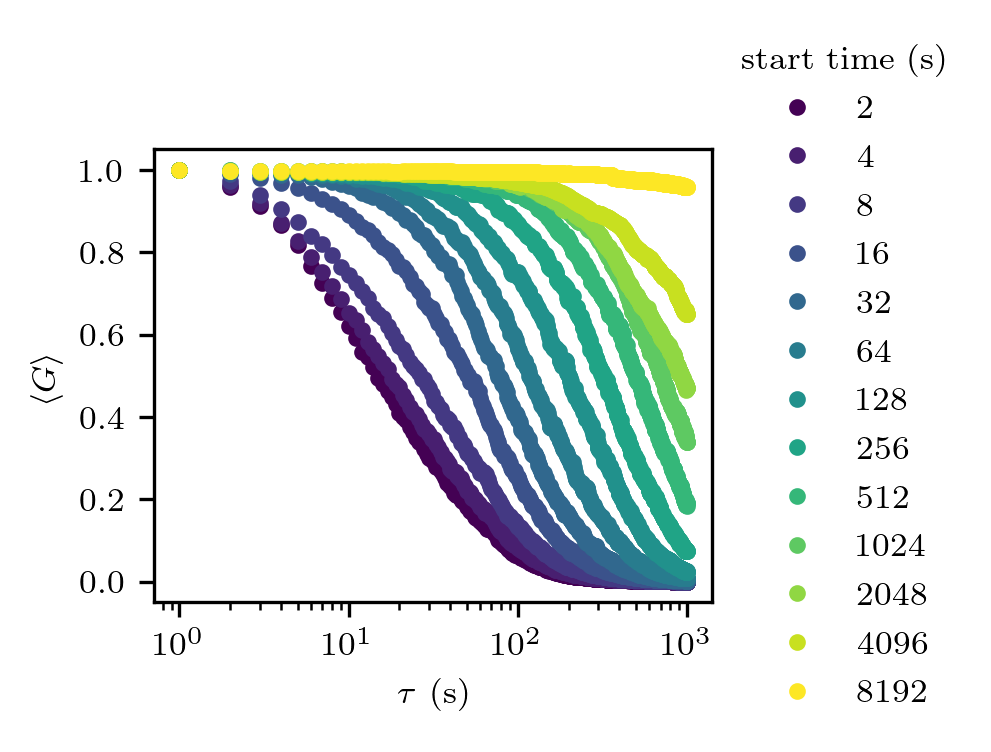

In [16]:
from matplotlib.pyplot import cm
a = np.logspace(1, 13, num=13, base=2)
# a = a*10/60
labels = list(a)

color=iter(cm.viridis(np.linspace(0,1,13)))
time = np.arange(1,1001,1)

fig = plt.figure(figsize=(3, 2))
ax1 = plt.subplot(111)

for t in range(13):
    c=next(color)
    ax1.plot(time,gp[t]  ,'o',color = c,markersize = 3,alpha = 1
             ,label = int(labels[t]))
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlim([0,1e6])

ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle G \rangle$')
box = ax1.get_position()
lgd = ax1.legend()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(title = 'start time (s)',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))


# plt.tight_layout()
# plt.savefig('strain_growth_time.png', bbox_inches='tight')

## e-folding timescale

In [17]:
t_efold = []
test = []

for i in range(len(gp)):
    x = means_undisturbed[i]
    y = np.where(x < 1/np.exp(1))[0]
    t_efold.append(y[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

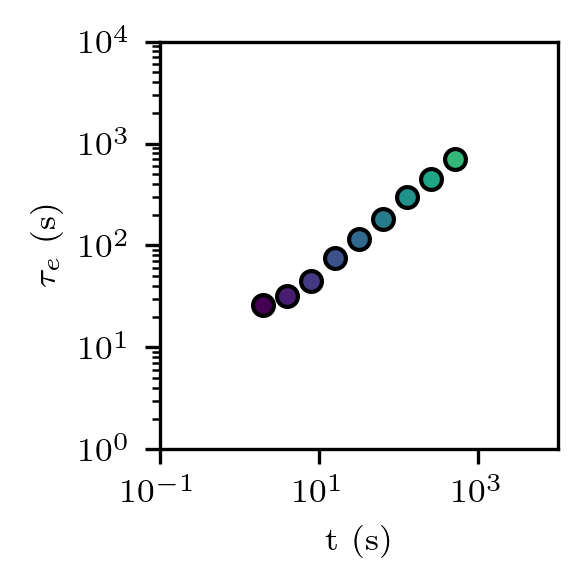

In [18]:
fig = plt.figure(figsize=(2, 2))
labels = (list(np.logspace(1, 13, num=13, base=2)))
# x = np.arange(1,300,1)
# y =  100*(x**(3/5))
# plt.plot(x,y,'k')
t = (np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis(np.linspace(0,1,13)))
for i in range(len(t_efold)):
    c=next(color)
    plt.plot(t[i],t_efold[i],'o',label = labels[i],markeredgecolor = 'k',color = c,markersize = 5)
# plt.title('relaxation timescale')
plt.xlabel('t (s)')
plt.ylabel(r'$\tau_e$ (s)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,1e4])
plt.ylim([1e0,1e4])
plt.tight_layout()
# plt.savefig('e_foldingtime_loglog.png', bbox_inches='tight')

## Exponential fit

In [19]:
from scipy.optimize import curve_fit

def exponential_fit(x,τ):
    return  np.exp(-x / τ)

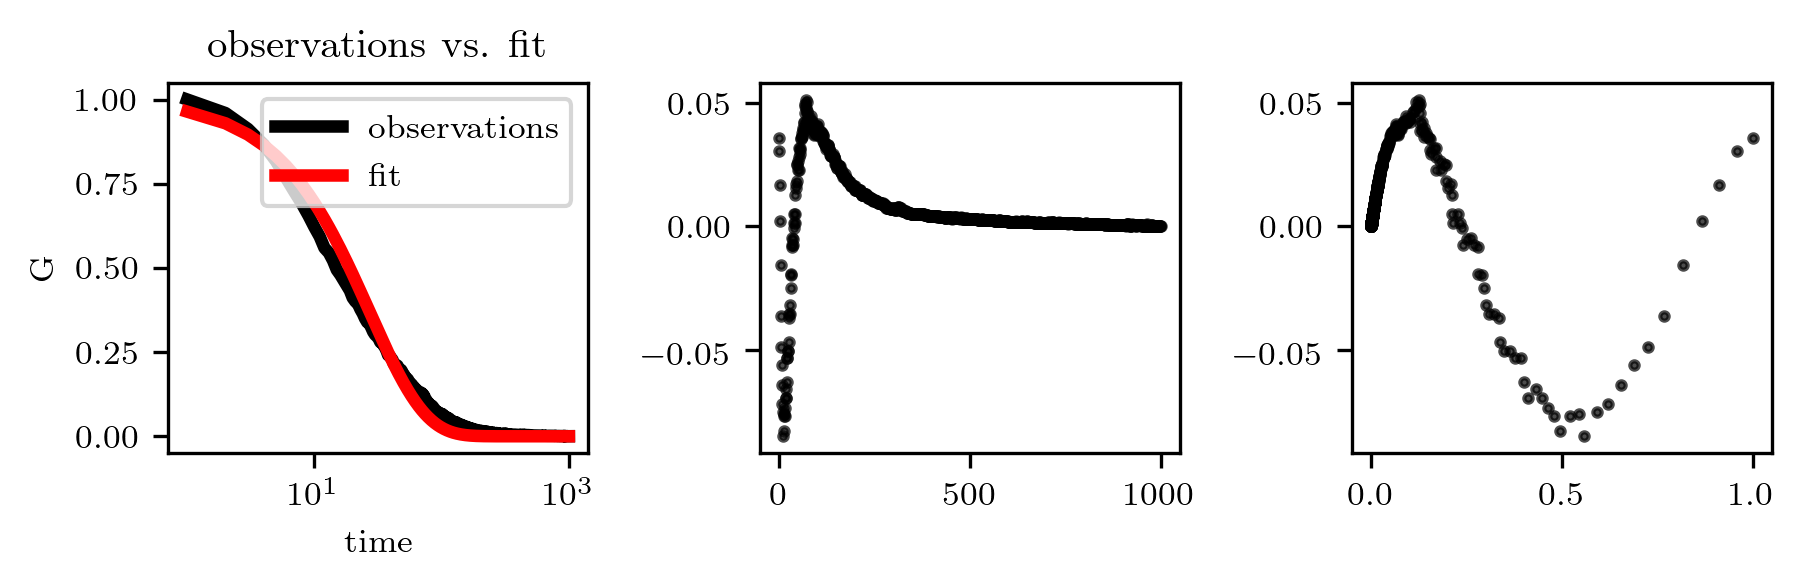

In [20]:
fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

xdata = np.arange(1, 1001, 1)
ydata = gp[0]

parameters, parameterscov = curve_fit(exponential_fit, xdata, ydata)#, bounds=(0,1))

y_fit = exponential_fit(xdata,*parameters)

ax1.plot(xdata,ydata,'k', linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')
ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()

ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

plt.tight_layout()

In [21]:
parameters

array([27.29155056])

Assessing goodness of fit

In [22]:
residuals = ydata - exponential_fit(xdata,*parameters)
## residual sum of squares
ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared 

0.9752710278447333

### A loop to automate fitting and parameter extraction

In [23]:
xdata = np.arange(1, 1001, 1)
n = 13
yfits = [[] for _ in range(n)]
ydata = [[] for _ in range(n)]

for i in range(n):
    ydata[i] = gp[i] 
    parameters, parameterscov = curve_fit(exponential_fit, xdata, ydata[i])#, bounds=(0,1))
    yfits[i] = exponential_fit(xdata,*parameters)

This loop cycles through the correlation function for the calculated start times and fits a stretched exponential to the data. Stored in the variable "fitting_parameters" are the fitted values and the covariance of each (see scipy_optimize for more information).

"fitting_parameters" is a nested list with dimensions

[start time] [popt,popcov] [τ]

In [24]:
fitting_parameters = [[] for _ in range(n)]
ydata = [[] for _ in range(n)]

for i in range(n):    
    ydata[i] = gp[i] 
    popt, pcov = curve_fit(exponential_fit, xdata, ydata[i])#, bounds=(0,1))
    fitting_parameters[i] = popt, pcov

plot decay timescale as a function of start times
note that the indices of fitting parameters depends on whether A and beta are included in the fit. here, we don't allow A to be a free parameter, and beta is fixed. its important to double check that the order of variables assigned in the fitting routine match the indices called here

In [25]:
tau = []

for i in range(n):
    tau.append(fitting_parameters[i][0][0])

## Efolding vs exponential fit

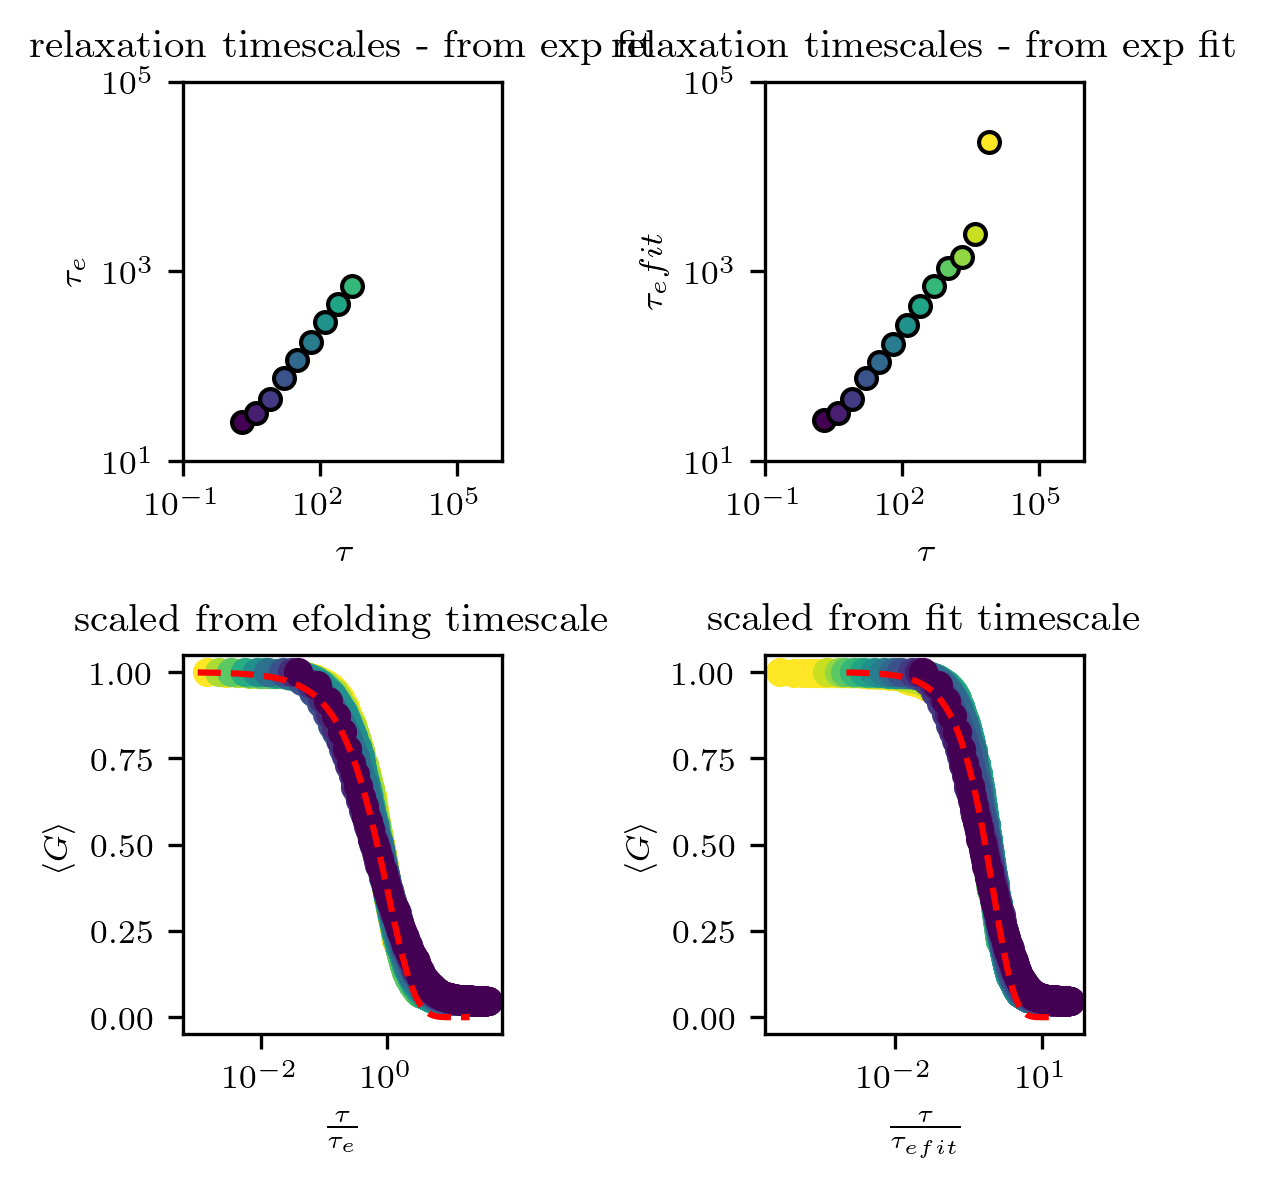

In [26]:
fig = plt.figure(figsize=(4, 4))


ax1 = plt.subplot(2, 2, 1)
t = np.logspace(1, 13, num=13, base=2)
color=iter(cm.viridis(np.linspace(0,1,13)))
for i in range(len(t_efold)):
    c=next(color)
    ax1.plot(t[i],t_efold[i],'o',color = c,markeredgecolor='k',markersize = 5)
ax1.set_title('relaxation timescales - from exp fit')
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$\tau_{e}$');
ax1.set_xlim([.1e0,1e6])
ax1.set_ylim([1e1,1e5])
ax1.set_xscale('log')
ax1.set_yscale('log')
##################################################################################################################
ax2 = plt.subplot(2, 2, 2)
t = np.logspace(1, 13, num=13, base=2)
color=iter(cm.viridis(np.linspace(0,1,13)))
for i in range(len(tau)):
    c=next(color)
    ax2.plot(t[i],tau[i],'o',color = c,markeredgecolor='k',markersize = 5)
ax2.set_title('relaxation timescales - from exp fit')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\tau_{e}fit$');
ax2.set_xlim([.1e0,1e6])
ax2.set_ylim([1e1,1e5])
ax2.set_xscale('log')
ax2.set_yscale('log')
##################################################################################################################
ax3 = plt.subplot(2, 2, 3)
n = len(t_efold)
t = np.arange(1, 1001,1)
color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(len(t_efold))):
    c=next(color)
    ax3.plot(t/t_efold[i],g[i],'o',color = c)
ax3.set_title('scaled from efolding timescale')
ax3.set_xscale('log')
ax3.set_xlabel(r'$\frac{\tau}{\tau_{e}}$')
ax3.set_ylabel(r'$\langle G\rangle$');
x = np.arange(0.001,20,.001)
y = np.exp((-x))
ax3.plot(x,y,'--r',label = 'exponential')
##################################################################################################################
ax4 = plt.subplot(2, 2, 4)
n = len(tau)
t = np.arange(1, 1001,1)
color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(len(tau))):
    c=next(color)
    ax4.plot(t/tau[i],g[i],'o',color = c)

ax4.set_title('scaled from fit timescale')
ax4.set_xscale('log')
ax4.set_xlabel(r'$\frac{\tau}{\tau_{efit}}$')
ax4.set_ylabel(r'$\langle G\rangle$');
ax4.plot(x,y,'--r',label = 'exponential')
##################################################################################################################

# from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Palatino']})
# plt.rcParams['pdf.fonttype'] = 42

plt.tight_layout()

## Determining the power of the timescale growth

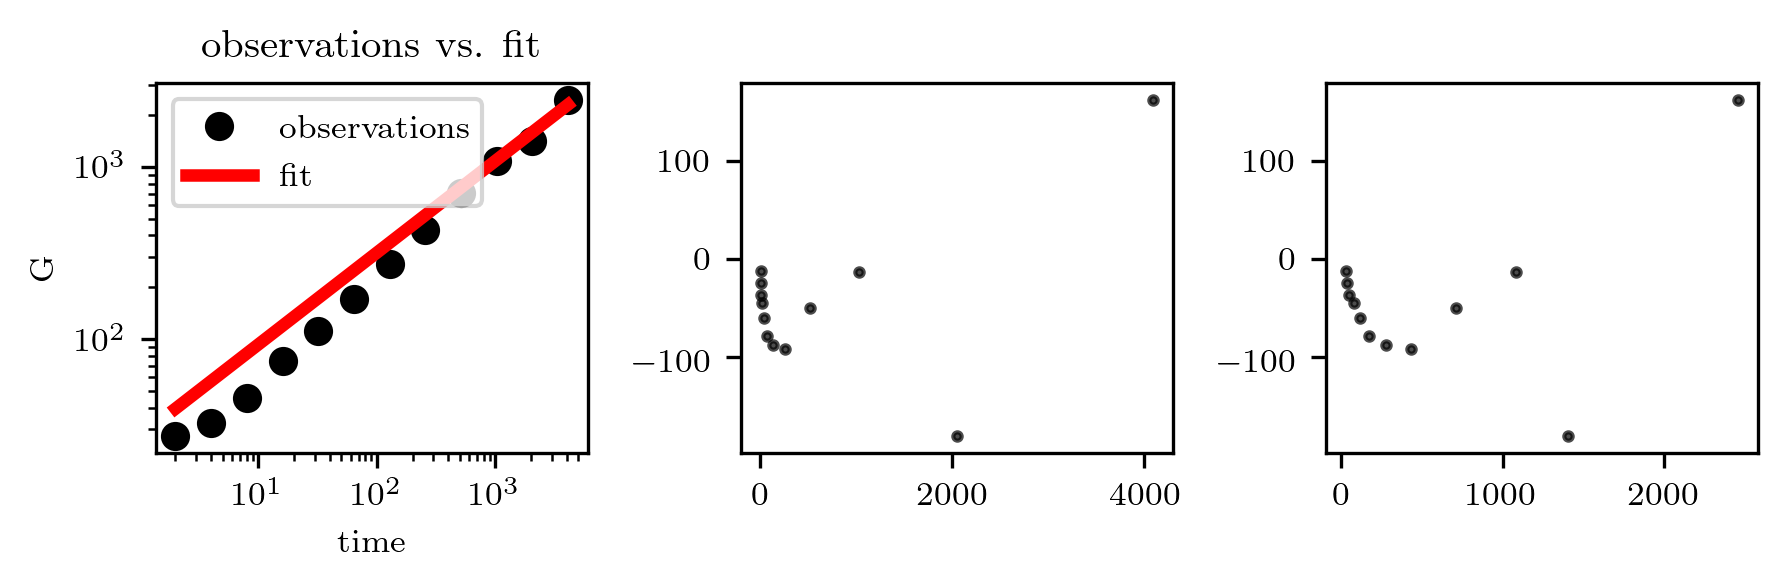

In [27]:
from scipy.optimize import curve_fit

a = np.min(tau[0:12])
t = np.logspace(1, 13, num=13, base=2)


def powerlaw(x,power):
    return a*(x**power)

fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

xdata = t[0:12]
ydata = tau[0:12]

parameters, parameterscov = curve_fit(powerlaw, xdata, ydata)#, bounds=(0,1))

y_fit = powerlaw(xdata,*parameters)

ax1.plot(xdata,ydata,'ok', linewidth = 3,label = 'observations')
ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()

ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

plt.tight_layout()

In [28]:
residuals = ydata - powerlaw(xdata,*parameters)
## residual sum of squares
ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared 

0.9849487287660513

In [29]:
parameters[0]

0.5331447622517197

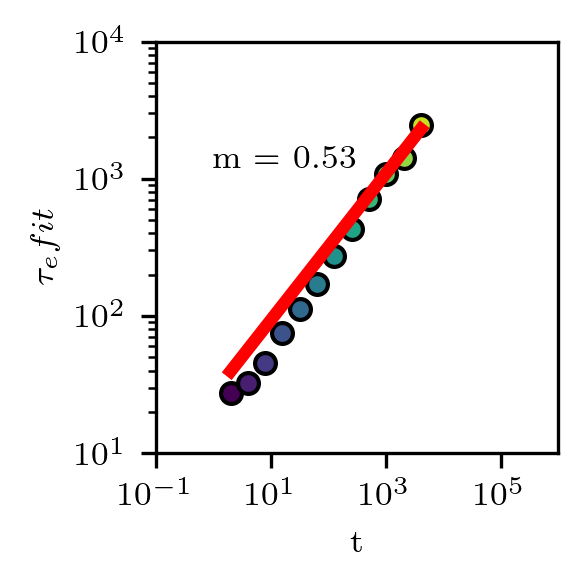

In [30]:
fig = plt.figure(figsize=(2, 2))

ax1 = plt.subplot(1, 1, 1)

t = np.logspace(1, 13, num=13, base=2)

y = 20*t**(parameters[0])


color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(tau)-1):
    c=next(color)
    ax1.plot(t[i],tau[i],'o',color = c,markeredgecolor='k',markersize = 5)

ax1.plot(xdata,y_fit,'r', linewidth = 3,label = 'fit')

ax1.annotate('m = 0.53', xy=(100, 500), xytext=(1, 1200),fontsize = 8)
    
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\tau_{e}fit$');
ax1.set_xlim([.1e0,1e6])
ax1.set_ylim([1e1,1e4])
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.tight_layout()

# plt.savefig('timescale_powerlaw_growth.png',bbox_inches='tight')

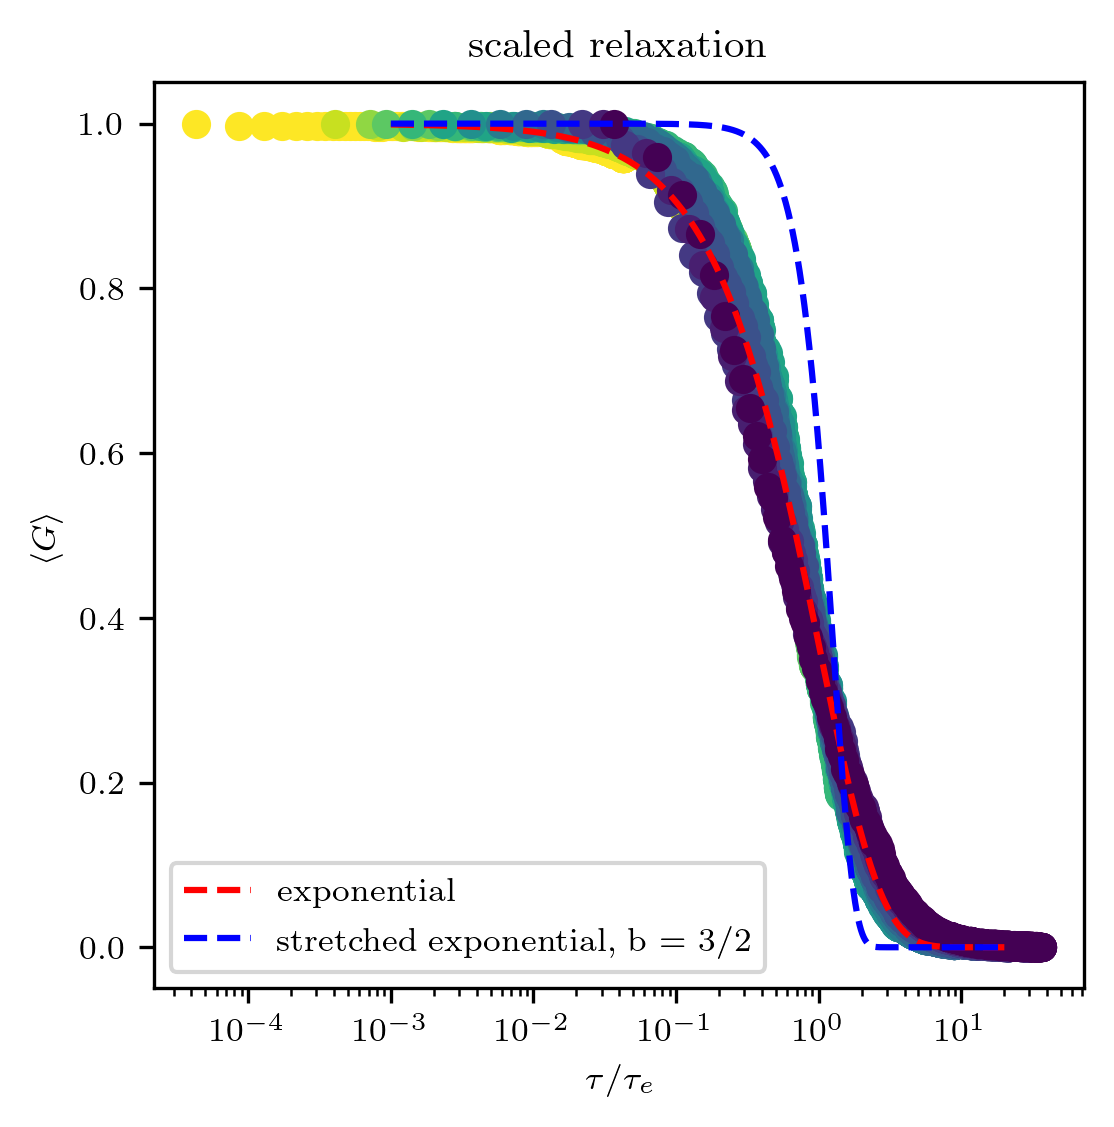

In [31]:
fig = plt.figure(figsize=(4, 4))

ax1 = plt.subplot(1, 1, 1)

n = 13
t = np.arange(1, 1001,1)

color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(n)):
    c=next(color)
    ax1.plot(t/tau[i],gp[i],'o',color = c)

ax1.set_title('scaled relaxation')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlabel(r'$ \tau / \tau_e  $')
ax1.set_ylabel(r'$ \langle G \rangle$');
# ax1.set_ylim([0,1.5]);

##################################################################################################################
x = np.arange(0.001,20,.001)
y1 = np.exp((-x))
y2 = np.exp((-x)**3/2)
y3 =((-x)**5)


ax1.plot(x,y1,'--r',label = 'exponential')
ax1.plot(x,y2,'--b',label = 'stretched exponential, b = 3/2')
# ax1.plot(x,y3,'--k',label = 'power-law')

##################################################################################################################
ax1.legend()
# plt.savefig('relaxation_stretchedvsnormalexp.png')

## Ensemble relaxation -- Figure 2. 

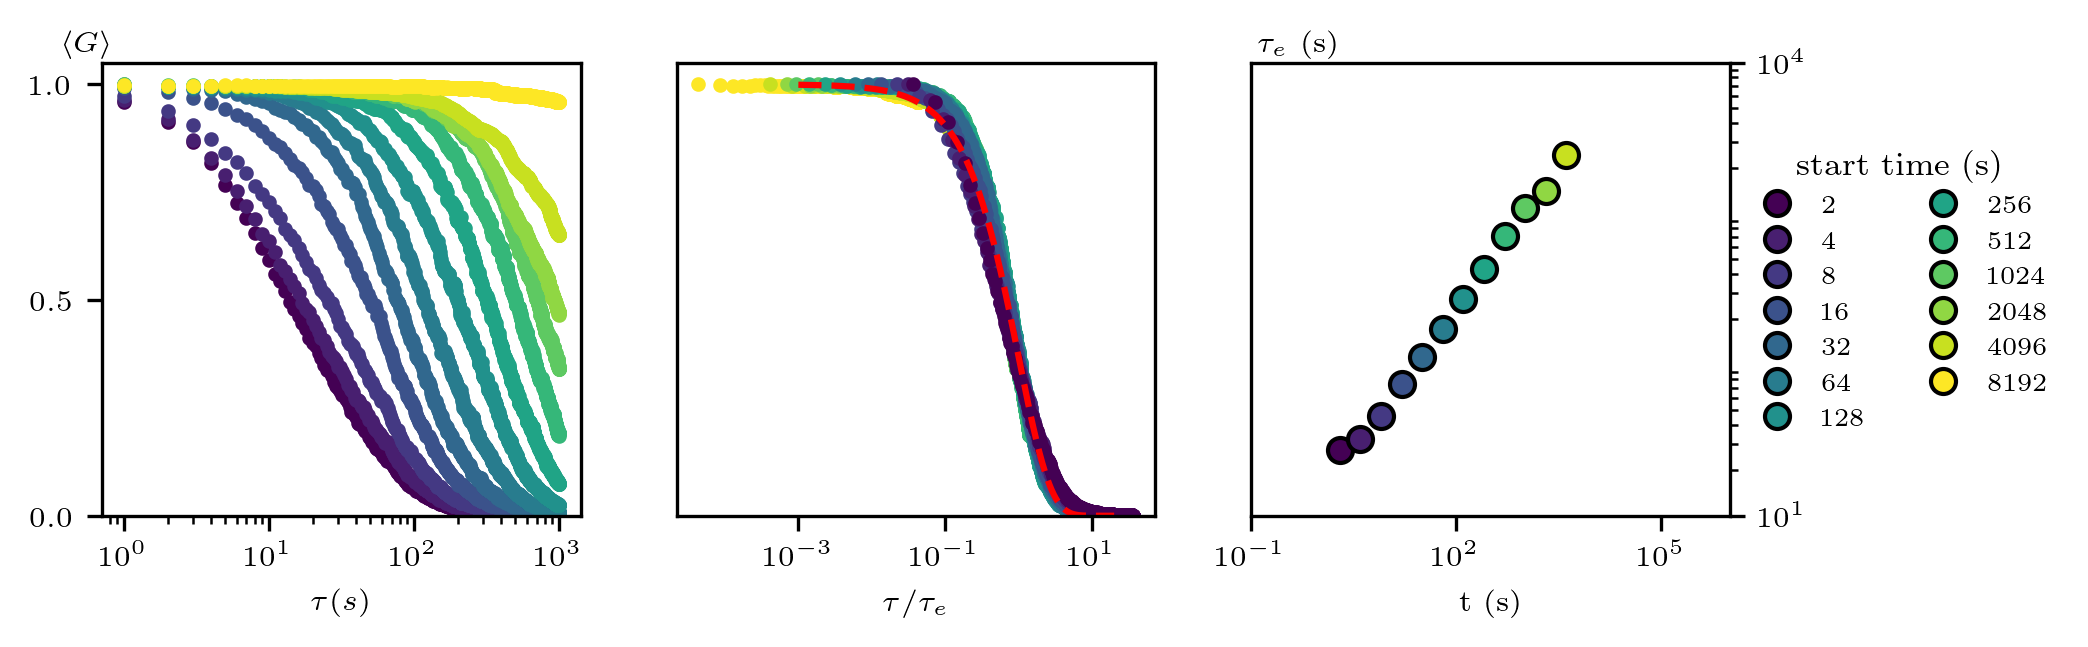

In [34]:
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(5,3))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

fs = 7

################################################################################################################
color=iter(cm.viridis(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax1.plot(gp[t],'o',color = c,markersize = 2.5)

ax1.set_ylim([0,1.05])
ax1.set_xscale('log')
ax1.set_xlabel(r'$ \tau (s)$',fontsize = fs)
ax1.set_ylabel(r'$ \langle G \rangle$',fontsize = fs,rotation = 'horizontal')
ax1.yaxis.set_ticks([0,.5,1])
ax1.yaxis.set_label_coords(-0.025,1.01)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.xaxis.set_ticks([1,10,100,1000])
################################################################################################################
t = np.arange(1, 1001)
color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(n)):
    c=next(color)
    ax2.plot(t/tau[i],gp[i],'o',color = c,markersize = 2.5)

ax2.set_ylim([0,1.05])
    
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.yaxis.set_ticks([])
ax2.set_xscale('log')

ax2.set_xticks([1e-5,1e-3,1e-1,1e1])
ax2.set_xlabel(r'$ \tau / \tau_e  $', fontsize = fs)

#showing the stretched exponential form
x = np.arange(0.001,20,.001)
y = np.exp((-x))
ax2.plot(x,y,'--r',label = 'exponential')
# ax2.plot(x,y,'r',linewidth = 2,label = r'$u/u_0 = e^{-z/\lambda}$')
# ax2.legend(frameon = False,loc = "lower left")
###############################################################################################################
t = (np.logspace(1, 13, num=13, base=2))
labels = list(np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(tau)):
    c=next(color)
    ax3.plot(t[i],tau[i],'o',markeredgecolor = 'k',color = c,markersize = 6,label = int(labels[i]))
    
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([.1e0,1e6])
ax3.set_ylim([1e1,1e4])
ax3.set_xticks([1e-1,1e2,1e5])
ax3.set_yticks([1e1,1e4])

ax3.set_ylabel(r'$\tau_e$ (s)',fontsize = fs,rotation = 'horizontal')
ax3.yaxis.set_label_coords(0.1,1.01)
ax3.set_xlabel('t (s)',fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.yaxis.tick_right()

lg = ax3.legend(title = 'start time (s)',ncol =2,loc='center left', frameon = False, bbox_to_anchor=(1, 0.5),fontsize = 6)

# plt.tight_layout()
#################################################################################################################
fig.set_size_inches(7, 2)
plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/figure3_glassyrelaxation_v1.svg',bbox_inches='tight')

# Profiles

Images from experiments are acquired from a level perspective - in order to measure surface-normal velocity/strain profiles, the images must be rotated by the angle of repose and cropped to a region of interest.

## Rotating images

In [ ]:
from skimage import transform

a = correlation_undisturbed[0][3]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=~binary)
img = masked_map
mask = ~binary

y_min = 70
y_max = 100 
x_min = 150
x_max = 200
rotation_angle = 27

rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
roi_verts.append(roi_verts[0])
x_roi, y_roi = zip(*roi_verts) 

cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]

plt.subplot(1,3,1)
plt.imshow(img,vmin = 0.9,vmax = 1,cmap = 'gray')
# plt.fill(x1,y1,'w',alpha = 1,edgecolor = 'k') 
plt.xlim([0,180])
plt.axis('off')

plt.title('unrotated image')
plt.subplot(1,3,2)
plt.imshow(rotated_masked_image,vmin = 0.9,vmax = 1,cmap = 'gray')
plt.fill(y_roi,x_roi,'w',alpha = .3,edgecolor = 'k') 
plt.axis('scaled')
plt.title('rotated image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin = 0.9,vmax = 1,cmap = 'gray')
plt.title('cropped and rotated image image')

plt.axis('off')

plt.tight_layout()


# plt.savefig('profile_protocol.svg')

## Computing depth-averaged quantities

In [ ]:
def depth_average(correlation_map):
    x = len(correlation_map)
    timestep = len(correlation_map)
    
    G_mean_depth_averaged = [[] for _ in range(x)]
    G_var_depth_averaged = [[] for _ in range(x)]
    
    ROI_average = []
    ROI_var = []
    
    # this loop
    for t in range(timestep-1):
        
        G_map_temp = correlation_map[t]
        G_map_rotated = transform.rotate(G_map_temp,rotation_angle,preserve_range = True,resize = True)
        G_map_cropped = np.asarray(G_map_rotated[y_min:y_max,x_min:x_max])
        
        cropped_rows = G_map_cropped.shape[0]
        cropped_columns = G_map_cropped.shape[1]
        cropped_area = cropped_rows*cropped_columns
        
        ROI_average.append(np.nanmean(G_map_cropped))
        ROI_var.append(np.nanvar(G_map_cropped))
        
        G_mean_temp = []
        G_var_temp = []
        
        for i in range(cropped_rows):
            G_mean_temp.append(np.nanmean(G_map_cropped[i][:]))
            G_var_temp.append(np.nanvar(G_map_cropped[i][:]))
            
        G_mean_depth_averaged[t] = G_mean_temp
        G_var_depth_averaged[t] = G_var_temp
        
        del G_map_temp,G_map_rotated,G_map_cropped,G_mean_temp,G_var_temp

    return G_mean_depth_averaged,G_var_depth_averaged,ROI_average,ROI_var

## A loop to calculate ROI - depth averaged quantities for all start times

In [ ]:
x = 13

mean_depth_avg = [[] for _ in range(x)]
var_depth_avg = [[] for _ in range(x)]
ROI_mean = [[] for _ in range(x)]
ROI_var = [[] for _ in range(x)]

for t in range(13):
    mean_depth_avg[t],var_depth_avg[t],ROI_mean[t],ROI_var[t] = depth_average(correlation_undisturbed[t])

In [ ]:
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

####################################################################################################################
a = np.logspace(1, 13, num=13, base=2)
# a = a*10/60
labels = list(a)

color=iter(cm.viridis(np.linspace(0,1,13)))
time = np.arange(1,1000,1)

for t in range(13):
    c=next(color)
    ax1.plot(time,ROI_mean[t],'o',color = c,markersize = 3,alpha = 1
             ,label = int(labels[t]))
ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle G \rangle$ - ROI')
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlim([0,1e6])
###################################################################################################################
color=iter(cm.viridis(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax2.plot(time,ROI_var[t],'o',color = c,markersize = 3,alpha = 1
             ,label = int(labels[t]))
ax2.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlim([0,1e6])

ax2.set_xlabel(r'$ \tau $ (s)')
ax2.set_ylabel('variance - ROI')
box = ax2.get_position()
lgd = ax2.legend()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(title = 'start time (s)',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))


plt.tight_layout()
# plt.savefig('strain_growth_time.png', bbox_inches='tight')

## Creating variables to correctly scale depth

In [ ]:
# this is the depth, in metapixels
z = np.arange(.5,(y_max-y_min),1)
#depth in pixels
z = z*10
#depth in meters
z = z*3.6e-5

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

profile_t2_0 = -(np.log(np.asarray(mean_depth_avg[0][0]))/c) 
profile_t2_2 = -(np.log(np.asarray(mean_depth_avg[0][2]))/c) 
profile_t2_4 = -(np.log(np.asarray(mean_depth_avg[0][4]))/c) 
profile_t2_6 = -(np.log(np.asarray(mean_depth_avg[0][6]))/c) 
profile_t2_8 = -(np.log(np.asarray(mean_depth_avg[0][8]))/c) 

profile_t2048_0 = -(np.log(np.asarray(mean_depth_avg[10][0]))/c) 
profile_t2048_200 = -(np.log(np.asarray(mean_depth_avg[10][200]))/c) 
profile_t2048_400 = -(np.log(np.asarray(mean_depth_avg[10][400]))/c) 
profile_t2048_600 = -(np.log(np.asarray(mean_depth_avg[10][600]))/c) 
profile_t2048_800 = -(np.log(np.asarray(mean_depth_avg[10][800]))/c) 

In [ ]:
fig = plt.figure(figsize=(6,3))

ax1 = plt.subplot(121)
ax1.plot(profile_t2_0,z,'yo',markersize = 7,markeredgecolor = 'k',label='τ = 0 s')
ax1.plot(profile_t2_2,z,'go',markersize = 7,markeredgecolor = 'k',label='τ = 2 s')
ax1.plot(profile_t2_4,z,'bo',markersize = 7,markeredgecolor = 'k',label='τ = 4 s')
ax1.plot(profile_t2_6,z,'ro',markersize = 7,markeredgecolor = 'k',label='τ = 6 s')
ax1.plot(profile_t2_8,z,'mo',markersize = 7,markeredgecolor = 'k',label='τ = 8 s')
ax1.invert_yaxis()
ax1.set_title('strain profiles: early time')
ax1.set_xlabel(r'$\langle \epsilon \rangle$')
ax1.set_ylabel('depth (m)')
ax1.legend(title = 'start time = 2s',frameon = False)
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax2 = plt.subplot(122)
ax2.plot(profile_t2048_0,z,'yo',markersize = 7,markeredgecolor = 'k',label='τ = 0 s')
ax2.plot(profile_t2048_200,z,'go',markersize = 7,markeredgecolor = 'k',label='τ = 200 s')
ax2.plot(profile_t2048_400,z,'bo',markersize = 7,markeredgecolor = 'k',label='τ = 400 s')
ax2.plot(profile_t2048_600,z,'ro',markersize = 7,markeredgecolor = 'k',label='τ = 600 s')
ax2.plot(profile_t2048_800,z,'mo',markersize = 7,markeredgecolor = 'k',label='τ = 800 s')
ax2.set_title('strain profiles: late time')
ax2.invert_yaxis()
ax2.set_xlabel(r'$\langle \epsilon \rangle$')
ax2.set_ylabel('depth (m)')
ax2.legend(title = 'start time = 2048s',frameon = False)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Latin Modern Math']})
# plt.rcParams['pdf.fonttype'] = 42

plt.tight_layout()

# plt.savefig('depth_profile.svg', bbox_inches='tight')

In [ ]:
np.savez('profiles_t2',data1 = z, data2 = profile_t2_0, data3 = profile_t2_2, data4 = profile_t2_4, data5 = profile_t2_6,data6 = profile_t2_8)

In [ ]:
np.savez('profiles_t2048',data1 = z, data2 = profile_t2048_0, data3 = profile_t2048_200, data4 = profile_t2048_400, data5 = profile_t2048_600,data6 = profile_t2048_800)

## ROI snapshots for both profiles

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(2,2))
ax1 = plt.subplot(111)

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

snapshot = rotated_test[y_min:y_max,x_min:x_max]
snapshot = -(np.log(snapshot)/c) 

im1 = ax1.imshow(snapshot,vmin = 1e-7,vmax = 1.5e-5,cmap = 'gray_r')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# cax.tick_params(labelsize=15) 
cax.set_title(r'$ \dot{\epsilon}$',fontsize = 10)

ax1.set_xticks([])
# ax1.set_yticks([])
# plt.axis('off')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Latin Modern Math']})
plt.rcParams['pdf.fonttype'] = 42

plt.tight_layout()
# plt.savefig('depth_profile_snapshot.svg', bbox_inches='tight')

## Fitting with scipy.optimize

In [ ]:
def normalize_profile(profile):
    # this gives a normalized profile
    profile_norm = profile/np.max(profile)
    profile_min = np.min(profile_norm)
    normalized = (profile_norm - profile_min)/(1-profile_min)
    return normalized

In [ ]:
norm = normalize_profile(profile_t2_8)

In [ ]:
from scipy.optimize import curve_fit

def func(z, l):
    return np.exp(-z/l)

x = z
y = (profile_t2_8/np.max(profile_t2_8))
y_norm = norm

popt, pcov = curve_fit(func, x, y)
popt_norm, pcov_norm = curve_fit(func, x, y_norm)

In [ ]:
fig = plt.figure(figsize=(6,3))

ax1 = plt.subplot(121)

ax1.plot(x, y, 'ko', label="Normalized data")
ax1.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
ax1.set_ylabel(r'$ \dot{\epsilon} / \dot{\epsilon_0} $')
ax1.set_xlabel('depth(m)')
# ax1.set_yscale('log')
ax1.legend()

ax2 = plt.subplot(122)
ax2.plot(x, y_norm, 'ko', label="Normalized Data - min")
ax2.plot(x, func(x, *popt_norm), 'r-', label="Fitted Curve")
ax2.set_ylim([0,1])
ax2.set_ylabel(r'$ (\dot{\epsilon} / \dot{\epsilon_0}) - min (\dot{\epsilon}) $')
ax2.set_xlabel('depth(m)')
# ax2.set_yscale('log')

ax2.legend()

# plt.savefig('profiles_linlog.png', bbox_inches='tight')

In [ ]:
def goodness_of_fit(xdata,ydata,popt):
    residuals = ydata - func(xdata,*popt)
    ## residual sum of squares
    ss_res = np.sum(residuals**2)
    # total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared 
    return r_squared

In [ ]:
r_2_DWS = goodness_of_fit(x, y,popt_DWS)
r_2_DWS

# Ensemble plot

In [ ]:
from matplotlib.pyplot import cm

#(figsize=(3.5,6))
fig = plt.figure(figsize=(5,2.5))
ax1 = plt.subplot(121)
ax3 = plt.subplot(122)

fs = 10

################################################################################################################
color=iter(cm.viridis(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax1.plot(means_undisturbed[t],'o',color = c,markersize = 3)

ax1.set_xscale('log')
# ax1.set_yscale('log')

# ax1.set_xlabel(r'$ \tau (s)$',fontsize = fs)
ax1.set_ylabel(r'$ \langle G \rangle$',fontsize = fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
################################################################################################################
left, bottom, width, height = [0.20, 0.60, 0.20, 0.10]
ax2 = fig.add_axes([left, bottom, width, height])

t = np.arange(1, 1001)
color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(n)):
    c=next(color)
    ax2.plot(t/tau[i],gp[i],'o',color = c,markersize = 2)
    
ax2.yaxis.set_ticks([0,1])
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.yaxis.set_label_coords(-0.025,1.05)

# ax2.xaxis.set_ticks([0,1e2])
# ax2.set_xlim([1e-3,1e2])

ax2.set_xscale('log')
ax2.set_xlabel(r'$ \tau / \tau_e  $')
ax2.set_ylabel(r'$ \langle G \rangle$',rotation = 'horizontal')
################################################################################################################
t = (np.logspace(1, 13, num=13, base=2))

labels = list(np.logspace(1, 13, num=13, base=2))

color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(tau)):
    c=next(color)
    ax3.plot(t[i],tau[i],'o',markeredgecolor = 'k',color = c,markersize = 6,label = int(labels[i]))
    
ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.set_ylim([5e0,1e6])
ax3.set_xlim([1e0,1e6])

ax3.set_ylabel(r'$\tau_e$ (s)',fontsize = fs)
ax3.set_xlabel('t (s)',fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)

# lg = ax3.legend(title = 'waiting time',loc='lower right', frameon =False,fontsize = 7)
lg = ax3.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5),fontsize = 7)
title = lg.get_title()
title.set_fontsize(10)

# from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Palatino']})
# plt.rcParams['pdf.fonttype'] = 42

# plt.savefig('relaxation_combined.pdf', bbox_inches='tight')

In [ ]:
from matplotlib.pyplot import cm

#(figsize=(3.5,6))
fig = plt.figure(figsize=(5,2.5))
ax1 = plt.subplot(121)
ax3 = plt.subplot(122)

fs = 10

################################################################################################################
color=iter(cm.viridis(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax1.plot(means_undisturbed[t],'o',color = c,markersize = 3)

ax1.set_xscale('log')
# ax1.set_yscale('log')

# ax1.set_xlabel(r'$ \tau (s)$',fontsize = fs)
ax1.set_ylabel(r'$ \langle G \rangle$',fontsize = fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
################################################################################################################
left, bottom, width, height = [0.17, 0.23, 0.10, 0.20]
ax2 = fig.add_axes([left, bottom, width, height])

t = np.arange(1, 1001)
color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(n)):
    c=next(color)
    ax2.plot(t/tau[i],gp[i],'o',color = c,markersize = 2)
    
ax2.yaxis.set_ticks([0,1])
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.yaxis.set_label_coords(-0.025,1.05)
ax2.xaxis.set_label_coords(1.2,-.15)

# ax2.xaxis.set_ticks([0,1e2])
# ax2.set_xlim([1e-3,1e2])

ax2.set_xscale('log')
ax2.set_xlabel(r'$ \tau / \tau_e  $')
ax2.set_ylabel(r'$ \langle G \rangle$',rotation = 'horizontal')
################################################################################################################
labels = list(np.logspace(1, 13, num=13, base=2))
t = (np.logspace(1, 13, num=13, base=2))


color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(tau)):
    c=next(color)
    ax3.plot(t[i],tau[i],'o',markeredgecolor = 'k',color = c,markersize = 6,label = int(labels[i]))
    
ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.set_xlim([1e-1,5e4])
ax3.set_ylim([1e1,1e4])

    
y = 20*t**(parameters[0])
ax3.plot(t,y,'--k')
ax3.annotate('m = 0.53', xy=(100, 500), xytext=(7, 1200),fontsize = 8)    

# ax3.set_ylabel(r'$\tau_e$ (s)',fontsize = fs)
ax3.set_xlabel('t (s)',fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
# lg = ax3.legend(title = 'waiting time', frameon =False,fontsize = 7)
# lg = ax3.legend(title = 'waiting time',loc='lower right', frameon =False,fontsize = 7)
# lg = ax3.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5),fontsize = 7)


# title = lg.get_title()
# title.set_fontsize(10)

# from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Latin Modern Math']})
# plt.rcParams['pdf.fonttype'] = 42

# plt.tight_layout()


plt.savefig('relaxation.jpg', bbox_inches='tight')

In [ ]:
y = 20*t**(parameters[0])


color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(tau)-1):
    c=next(color)
    ax1.plot(t[i],tau[i],'o',color = c,markeredgecolor='k',markersize = 5)

ax1.plot(t,y,'--k')
ax1.annotate('m = 0.53', xy=(100, 500), xytext=(1, 1200),fontsize = 8)
    
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\tau_{e}fit$');
ax1.set_xlim([.1e0,1e6])
ax1.set_ylim([1e1,1e4])
ax1.set_xscale('log')
ax1.set_yscale('log')


In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))
################################################################################################################
labels = list(np.logspace(1, 13, num=13, base=2))
n = 13
time = np.arange(1, 1001)
t = (np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(n)):
    c=next(color)
    ax1.plot(time,gp[i],'o',color = c,markersize = 8,alpha = 1,label = int(labels[i]))
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel('τ / τ decay',fontsize = 10)
ax1.set_ylabel('G',fontsize = 10)
ax1.legend(title = 'start time (s)',frameon = True,loc='lower left',fontsize = 10 )        
################################################################################################################
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.75, 0.75, 0.2, 0.2]

ax2 = fig.add_axes([left, bottom, width, height])

color=iter(cm.viridis_r(np.linspace(0,1,n)))

for i in reversed(range(n)):
    c=next(color)
    ax2.plot(t[i],tau[i],'o',color = c,markersize = 3)
ax2.set_xscale('log')
ax2.set_xlabel('τ ')
ax2.set_ylabel('G')


################################################################################################################

# plt.xscale('log')
# plt.yscale('log')
# plt.tight_layout()
# plt.savefig('relaxation_a.png')

In [ ]:
fig = plt.figure(figsize=(2, 2))

t = (np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(t_efold)):
    c=next(color)
    plt.plot(t[i],t_efold[i],'o',markeredgecolor = 'k',color = c,markersize = 5)
plt.xlabel('start time (s)', fontsize=10)
plt.ylabel('relaxation time (s)', fontsize=10)

# plt.xscale('log')
# plt.yscale('log')

# plt.savefig('relaxation_b.png')

In [ ]:
import pylab as pl
import numpy as np

a = np.array([[1e-5,1e-7]])
pl.figure(figsize=(.25,3))
img = pl.imshow(a, cmap="gray_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cax.set_title(r'$\dot{\epsilon }$',fontsize = 24)
cax.tick_params(labelsize=10) 
pl.colorbar(orientation="vertical", cax=cax,format='%.0e',ticks = [1e-7,2.5e-6,5e-6,7.5e-6,1e-5])

pl.savefig("colorbar.png", bbox_inches='tight')